# Lab-2: Deep Learning Experiments

## Tasks:
- **Task 1:** Compare activation functions (Sigmoid, Tanh, ReLU)
- **Task 2:** Compare optimizers (SGD, SGD with Momentum, Adam)
- **Task 3:** Test Batch Normalization and Dropout scenarios


### Setup & Dataset (MNIST)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Using device: cpu
Train dataset size: 60000
Test dataset size: 10000


### Model Definition


In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, activation='relu', use_bn=False, dropout_rate=0.0):
        super(NeuralNetwork, self).__init__()
        
        # Select activation function
        if activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'relu':
            self.activation = nn.ReLU()
        else:
            raise ValueError(f"Unknown activation: '{activation}'. Valid options are: 'sigmoid', 'tanh', 'relu'")
        
        self.use_bn = use_bn
        
        # Define layers
        self.fc1 = nn.Linear(784, 128)
        self.bn1 = nn.BatchNorm1d(128) if use_bn else None
        self.dropout1 = nn.Dropout(dropout_rate) if dropout_rate > 0 else None
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64) if use_bn else None
        self.dropout2 = nn.Dropout(dropout_rate) if dropout_rate > 0 else None
        
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        
        x = self.fc1(x)
        if self.use_bn:
            x = self.bn1(x)
        x = self.activation(x)
        if self.dropout1 is not None:
            x = self.dropout1(x)
        
        x = self.fc2(x)
        if self.use_bn:
            x = self.bn2(x)
        x = self.activation(x)
        if self.dropout2 is not None:
            x = self.dropout2(x)
        
        x = self.fc3(x)
        return x

### Training & Testing Functions


In [4]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
    
    avg_loss = total_loss / len(loader)
    acc = 100. * correct / len(loader.dataset)
    return avg_loss, acc


def test(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    
    avg_loss = total_loss / len(loader)
    acc = 100. * correct / len(loader.dataset)
    return avg_loss, acc


def run_experiment(model, optimizer, epochs=10, exp_name="Experiment"):
    """Run training and testing for specified epochs"""
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    
    print(f"\n{exp_name}")
    print("=" * 60)
    
    try:
        for epoch in range(epochs):
            train_loss, train_acc = train(model, train_loader, optimizer, criterion)
            test_loss, test_acc = test(model, test_loader, criterion)
            
            # Check for NaN values
            if np.isnan(train_loss) or np.isnan(test_loss):
                print(f"\nWarning: NaN detected at epoch {epoch+1}. Stopping training.")
                break
            
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            
            print(f"Epoch {epoch+1:2d}/{epochs}: "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    
    except RuntimeError as e:
        print(f"\nError during training: {e}")
        print("Training stopped early.")
    
    return {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'test_accs': test_accs,
        'final_test_acc': test_accs[-1] if test_accs else 0.0
    }

## Task 1: The Activation Function Challenge

Compare the training loss and accuracy curves when using:
- **Sigmoid**: Observe if the model suffers from "vanishing gradients" or slow start
- **Tanh**: Compare its speed to Sigmoid
- **ReLU**: Document why this usually leads to faster convergence


In [5]:
# Experiment 1: Sigmoid Activation
model_sigmoid = NeuralNetwork(activation='sigmoid').to(device)
optimizer_sigmoid = optim.SGD(model_sigmoid.parameters(), lr=0.01)
results_sigmoid = run_experiment(model_sigmoid, optimizer_sigmoid, epochs=10, 
                                  exp_name="Task 1.1: Sigmoid + SGD")


Task 1.1: Sigmoid + SGD
Epoch  1/10: Train Loss: 2.2935, Train Acc: 11.77% | Test Loss: 2.2782, Test Acc: 11.37%
Epoch  2/10: Train Loss: 2.2632, Train Acc: 20.44% | Test Loss: 2.2430, Test Acc: 30.31%
Epoch  3/10: Train Loss: 2.2153, Train Acc: 36.23% | Test Loss: 2.1759, Test Acc: 38.13%
Epoch  4/10: Train Loss: 2.1193, Train Acc: 44.72% | Test Loss: 2.0411, Test Acc: 49.36%
Epoch  5/10: Train Loss: 1.9442, Train Acc: 50.12% | Test Loss: 1.8234, Test Acc: 54.77%
Epoch  6/10: Train Loss: 1.7055, Train Acc: 55.32% | Test Loss: 1.5691, Test Acc: 59.69%
Epoch  7/10: Train Loss: 1.4591, Train Acc: 60.98% | Test Loss: 1.3382, Test Acc: 64.60%
Epoch  8/10: Train Loss: 1.2533, Train Acc: 66.01% | Test Loss: 1.1588, Test Acc: 67.21%
Epoch  9/10: Train Loss: 1.0972, Train Acc: 69.36% | Test Loss: 1.0235, Test Acc: 72.27%
Epoch 10/10: Train Loss: 0.9783, Train Acc: 73.37% | Test Loss: 0.9182, Test Acc: 75.19%


In [6]:
# Experiment 2: Tanh Activation
model_tanh = NeuralNetwork(activation='tanh').to(device)
optimizer_tanh = optim.SGD(model_tanh.parameters(), lr=0.01)
results_tanh = run_experiment(model_tanh, optimizer_tanh, epochs=10, 
                               exp_name="Task 1.2: Tanh + SGD")


Task 1.2: Tanh + SGD
Epoch  1/10: Train Loss: 1.1672, Train Acc: 76.42% | Test Loss: 0.6263, Test Acc: 87.23%
Epoch  2/10: Train Loss: 0.5069, Train Acc: 88.24% | Test Loss: 0.4105, Test Acc: 89.69%
Epoch  3/10: Train Loss: 0.3820, Train Acc: 90.01% | Test Loss: 0.3404, Test Acc: 90.86%
Epoch  4/10: Train Loss: 0.3294, Train Acc: 91.03% | Test Loss: 0.3037, Test Acc: 91.49%
Epoch  5/10: Train Loss: 0.2975, Train Acc: 91.72% | Test Loss: 0.2805, Test Acc: 92.12%
Epoch  6/10: Train Loss: 0.2741, Train Acc: 92.28% | Test Loss: 0.2611, Test Acc: 92.56%
Epoch  7/10: Train Loss: 0.2552, Train Acc: 92.72% | Test Loss: 0.2459, Test Acc: 93.03%
Epoch  8/10: Train Loss: 0.2389, Train Acc: 93.15% | Test Loss: 0.2323, Test Acc: 93.32%
Epoch  9/10: Train Loss: 0.2246, Train Acc: 93.64% | Test Loss: 0.2199, Test Acc: 93.67%
Epoch 10/10: Train Loss: 0.2117, Train Acc: 94.01% | Test Loss: 0.2085, Test Acc: 93.87%


In [7]:
# Experiment 3: ReLU Activation
model_relu = NeuralNetwork(activation='relu').to(device)
optimizer_relu = optim.SGD(model_relu.parameters(), lr=0.01)
results_relu = run_experiment(model_relu, optimizer_relu, epochs=10, 
                               exp_name="Task 1.3: ReLU + SGD")


Task 1.3: ReLU + SGD
Epoch  1/10: Train Loss: 1.2100, Train Acc: 69.31% | Test Loss: 0.4801, Test Acc: 87.63%
Epoch  2/10: Train Loss: 0.4067, Train Acc: 88.86% | Test Loss: 0.3336, Test Acc: 90.56%
Epoch  3/10: Train Loss: 0.3229, Train Acc: 90.75% | Test Loss: 0.2892, Test Acc: 91.83%
Epoch  4/10: Train Loss: 0.2849, Train Acc: 91.75% | Test Loss: 0.2595, Test Acc: 92.68%
Epoch  5/10: Train Loss: 0.2589, Train Acc: 92.44% | Test Loss: 0.2399, Test Acc: 93.02%
Epoch  6/10: Train Loss: 0.2385, Train Acc: 93.19% | Test Loss: 0.2207, Test Acc: 93.63%
Epoch  7/10: Train Loss: 0.2203, Train Acc: 93.60% | Test Loss: 0.2069, Test Acc: 93.86%
Epoch  8/10: Train Loss: 0.2046, Train Acc: 94.11% | Test Loss: 0.1951, Test Acc: 94.29%
Epoch  9/10: Train Loss: 0.1910, Train Acc: 94.50% | Test Loss: 0.1832, Test Acc: 94.75%
Epoch 10/10: Train Loss: 0.1788, Train Acc: 94.89% | Test Loss: 0.1723, Test Acc: 95.01%


### Task 1: Analysis of Activation Functions

**Observations:**

1. **Sigmoid:**
   - Often suffers from vanishing gradient problem
   - Outputs are between 0 and 1, which can slow down learning
   - May show slower convergence especially in deeper networks

2. **Tanh:**
   - Outputs are between -1 and 1 (zero-centered)
   - Generally faster than Sigmoid due to zero-centered outputs
   - Still can suffer from vanishing gradients

3. **ReLU:**
   - No vanishing gradient problem for positive values
   - Faster convergence due to simpler gradient computation
   - Helps with sparse activation (some neurons output 0)
   - Most commonly used in modern deep learning


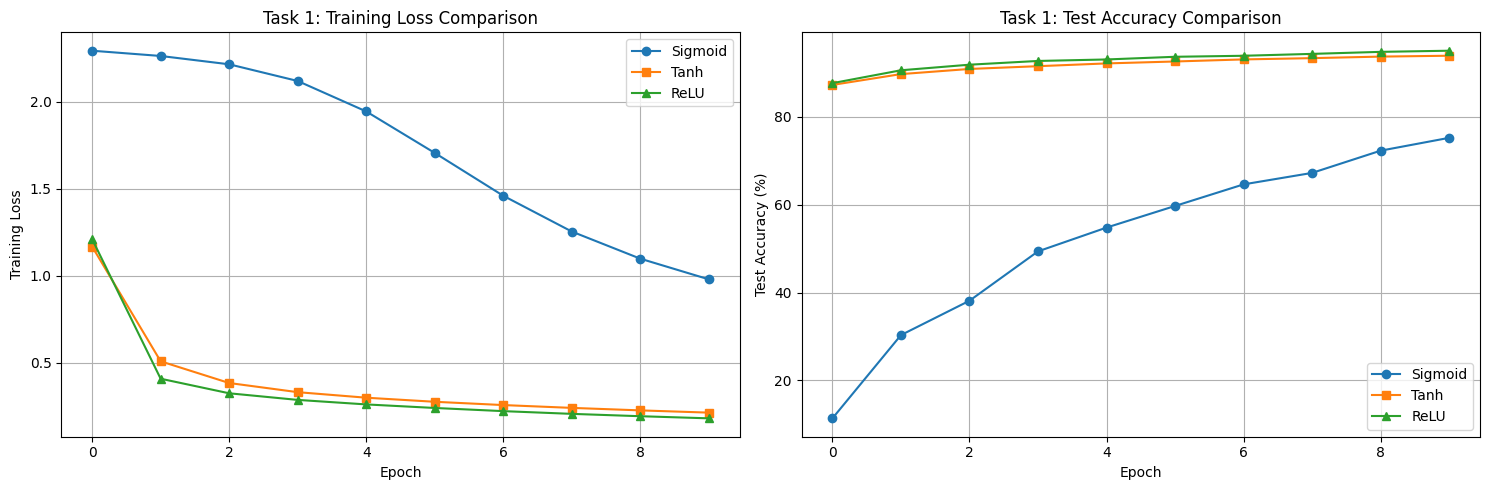


Final Test Accuracies:
Sigmoid: 75.19%
Tanh: 93.87%
ReLU: 95.01%


In [8]:
# Plot Task 1 Results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training Loss Comparison
axes[0].plot(results_sigmoid['train_losses'], label='Sigmoid', marker='o')
axes[0].plot(results_tanh['train_losses'], label='Tanh', marker='s')
axes[0].plot(results_relu['train_losses'], label='ReLU', marker='^')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Task 1: Training Loss Comparison')
axes[0].legend()
axes[0].grid(True)

# Test Accuracy Comparison
axes[1].plot(results_sigmoid['test_accs'], label='Sigmoid', marker='o')
axes[1].plot(results_tanh['test_accs'], label='Tanh', marker='s')
axes[1].plot(results_relu['test_accs'], label='ReLU', marker='^')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Test Accuracy (%)')
axes[1].set_title('Task 1: Test Accuracy Comparison')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("\nFinal Test Accuracies:")
print(f"Sigmoid: {results_sigmoid['final_test_acc']:.2f}%")
print(f"Tanh: {results_tanh['final_test_acc']:.2f}%")
print(f"ReLU: {results_relu['final_test_acc']:.2f}%")

## Task 2: The Optimizer Showdown

Using the best activation function (ReLU), compare different optimizers:
- **SGD**: Observe the stability of the loss
- **SGD with Momentum**: Note how it handles "bumps" in the loss landscape
- **Adam**: Observe how quickly it reaches high accuracy compared to basic SGD


In [9]:
# Experiment 4: ReLU + SGD (without momentum)
model_sgd = NeuralNetwork(activation='relu').to(device)
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)
results_sgd = run_experiment(model_sgd, optimizer_sgd, epochs=10, 
                              exp_name="Task 2.1: ReLU + SGD")


Task 2.1: ReLU + SGD
Epoch  1/10: Train Loss: 1.2000, Train Acc: 71.25% | Test Loss: 0.4788, Test Acc: 87.58%
Epoch  2/10: Train Loss: 0.4123, Train Acc: 88.64% | Test Loss: 0.3414, Test Acc: 90.29%
Epoch  3/10: Train Loss: 0.3322, Train Acc: 90.45% | Test Loss: 0.2955, Test Acc: 91.40%
Epoch  4/10: Train Loss: 0.2948, Train Acc: 91.40% | Test Loss: 0.2685, Test Acc: 92.25%
Epoch  5/10: Train Loss: 0.2685, Train Acc: 92.13% | Test Loss: 0.2449, Test Acc: 92.86%
Epoch  6/10: Train Loss: 0.2459, Train Acc: 92.88% | Test Loss: 0.2285, Test Acc: 93.34%
Epoch  7/10: Train Loss: 0.2266, Train Acc: 93.47% | Test Loss: 0.2118, Test Acc: 93.82%
Epoch  8/10: Train Loss: 0.2099, Train Acc: 93.91% | Test Loss: 0.1981, Test Acc: 93.98%
Epoch  9/10: Train Loss: 0.1953, Train Acc: 94.35% | Test Loss: 0.1869, Test Acc: 94.34%
Epoch 10/10: Train Loss: 0.1827, Train Acc: 94.74% | Test Loss: 0.1750, Test Acc: 94.72%


In [10]:
# Experiment 5: ReLU + SGD with Momentum
model_momentum = NeuralNetwork(activation='relu').to(device)
optimizer_momentum = optim.SGD(model_momentum.parameters(), lr=0.01, momentum=0.9)
results_momentum = run_experiment(model_momentum, optimizer_momentum, epochs=10, 
                                   exp_name="Task 2.2: ReLU + SGD with Momentum")


Task 2.2: ReLU + SGD with Momentum
Epoch  1/10: Train Loss: 0.4530, Train Acc: 86.66% | Test Loss: 0.2029, Test Acc: 94.13%
Epoch  2/10: Train Loss: 0.1656, Train Acc: 95.14% | Test Loss: 0.1325, Test Acc: 95.97%
Epoch  3/10: Train Loss: 0.1112, Train Acc: 96.72% | Test Loss: 0.1033, Test Acc: 96.88%
Epoch  4/10: Train Loss: 0.0853, Train Acc: 97.47% | Test Loss: 0.0912, Test Acc: 97.15%
Epoch  5/10: Train Loss: 0.0671, Train Acc: 97.99% | Test Loss: 0.0873, Test Acc: 97.18%
Epoch  6/10: Train Loss: 0.0545, Train Acc: 98.36% | Test Loss: 0.0774, Test Acc: 97.54%
Epoch  7/10: Train Loss: 0.0445, Train Acc: 98.66% | Test Loss: 0.0820, Test Acc: 97.42%
Epoch  8/10: Train Loss: 0.0371, Train Acc: 98.90% | Test Loss: 0.0770, Test Acc: 97.50%
Epoch  9/10: Train Loss: 0.0308, Train Acc: 99.10% | Test Loss: 0.0741, Test Acc: 97.59%
Epoch 10/10: Train Loss: 0.0252, Train Acc: 99.28% | Test Loss: 0.0718, Test Acc: 97.78%


In [11]:
# Experiment 6: ReLU + Adam
model_adam = NeuralNetwork(activation='relu').to(device)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)
results_adam = run_experiment(model_adam, optimizer_adam, epochs=10, 
                               exp_name="Task 2.3: ReLU + Adam")


Task 2.3: ReLU + Adam
Epoch  1/10: Train Loss: 0.3219, Train Acc: 90.64% | Test Loss: 0.1515, Test Acc: 95.41%
Epoch  2/10: Train Loss: 0.1271, Train Acc: 96.24% | Test Loss: 0.1194, Test Acc: 96.20%
Epoch  3/10: Train Loss: 0.0882, Train Acc: 97.34% | Test Loss: 0.0946, Test Acc: 97.08%
Epoch  4/10: Train Loss: 0.0685, Train Acc: 97.86% | Test Loss: 0.0841, Test Acc: 97.47%
Epoch  5/10: Train Loss: 0.0550, Train Acc: 98.25% | Test Loss: 0.0755, Test Acc: 97.62%
Epoch  6/10: Train Loss: 0.0436, Train Acc: 98.63% | Test Loss: 0.0791, Test Acc: 97.60%
Epoch  7/10: Train Loss: 0.0350, Train Acc: 98.86% | Test Loss: 0.0762, Test Acc: 97.90%
Epoch  8/10: Train Loss: 0.0323, Train Acc: 98.98% | Test Loss: 0.0839, Test Acc: 97.64%
Epoch  9/10: Train Loss: 0.0257, Train Acc: 99.16% | Test Loss: 0.0824, Test Acc: 97.77%
Epoch 10/10: Train Loss: 0.0235, Train Acc: 99.23% | Test Loss: 0.1013, Test Acc: 97.59%


### Task 2: Analysis of Optimizers

**Observations:**

1. **SGD (Stochastic Gradient Descent):**
   - Simple and straightforward optimization
   - May show more oscillations in loss
   - Slower convergence compared to adaptive methods

2. **SGD with Momentum:**
   - Accelerates convergence by accumulating gradients
   - Smooths out oscillations in the loss landscape
   - Better at escaping local minima

3. **Adam (Adaptive Moment Estimation):**
   - Combines advantages of momentum and adaptive learning rates
   - Usually fastest convergence
   - Works well with default hyperparameters


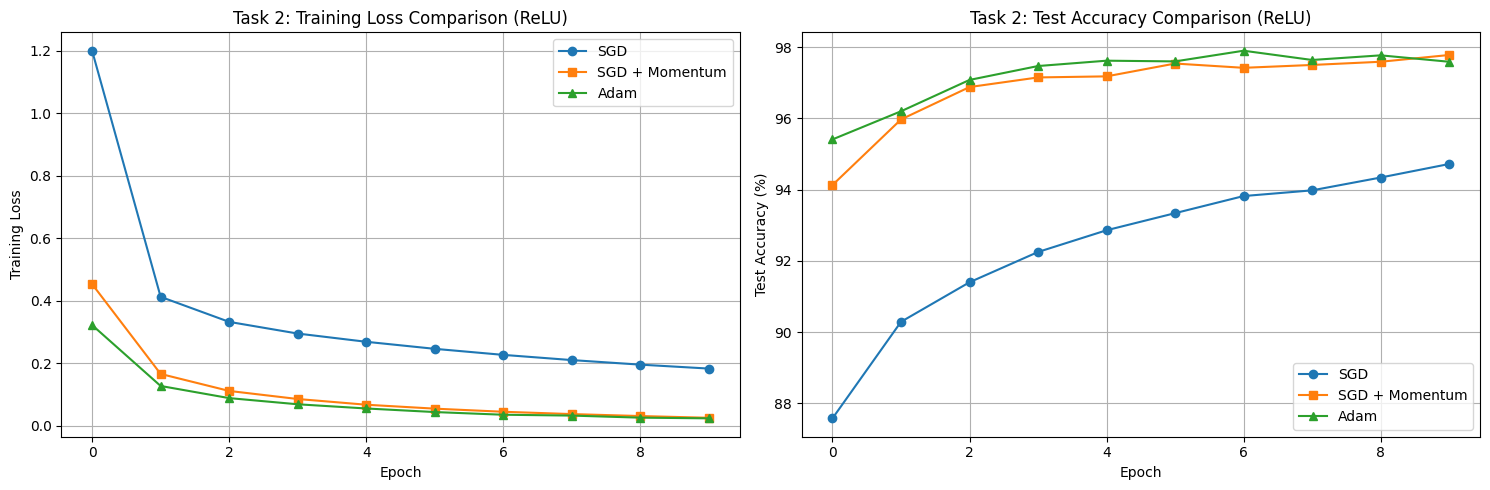


Final Test Accuracies:
SGD: 94.72%
SGD + Momentum: 97.78%
Adam: 97.59%


In [12]:
# Plot Task 2 Results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training Loss Comparison
axes[0].plot(results_sgd['train_losses'], label='SGD', marker='o')
axes[0].plot(results_momentum['train_losses'], label='SGD + Momentum', marker='s')
axes[0].plot(results_adam['train_losses'], label='Adam', marker='^')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Task 2: Training Loss Comparison (ReLU)')
axes[0].legend()
axes[0].grid(True)

# Test Accuracy Comparison
axes[1].plot(results_sgd['test_accs'], label='SGD', marker='o')
axes[1].plot(results_momentum['test_accs'], label='SGD + Momentum', marker='s')
axes[1].plot(results_adam['test_accs'], label='Adam', marker='^')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Test Accuracy (%)')
axes[1].set_title('Task 2: Test Accuracy Comparison (ReLU)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("\nFinal Test Accuracies:")
print(f"SGD: {results_sgd['final_test_acc']:.2f}%")
print(f"SGD + Momentum: {results_momentum['final_test_acc']:.2f}%")
print(f"Adam: {results_adam['final_test_acc']:.2f}%")

## Task 3: Batch Normalization and Dropout

Run specific scenarios to observe the contrast:
- **WITHOUT Batch Normalization and Dropout**
- **Without BN, Dropout=0.1**
- **With BN, Dropout=0.25**


In [13]:
# Experiment 7: Without BN, Without Dropout
model_no_bn_no_drop = NeuralNetwork(activation='relu', use_bn=False, dropout_rate=0.0).to(device)
optimizer_7 = optim.Adam(model_no_bn_no_drop.parameters(), lr=0.001)
results_no_bn_no_drop = run_experiment(model_no_bn_no_drop, optimizer_7, epochs=10, 
                                        exp_name="Task 3.1: No BN, No Dropout")


Task 3.1: No BN, No Dropout
Epoch  1/10: Train Loss: 0.3262, Train Acc: 90.41% | Test Loss: 0.1636, Test Acc: 95.14%
Epoch  2/10: Train Loss: 0.1357, Train Acc: 95.92% | Test Loss: 0.1111, Test Acc: 96.42%
Epoch  3/10: Train Loss: 0.0934, Train Acc: 97.10% | Test Loss: 0.0944, Test Acc: 97.13%
Epoch  4/10: Train Loss: 0.0715, Train Acc: 97.75% | Test Loss: 0.0867, Test Acc: 97.36%
Epoch  5/10: Train Loss: 0.0550, Train Acc: 98.30% | Test Loss: 0.0839, Test Acc: 97.42%
Epoch  6/10: Train Loss: 0.0441, Train Acc: 98.58% | Test Loss: 0.0819, Test Acc: 97.58%
Epoch  7/10: Train Loss: 0.0368, Train Acc: 98.81% | Test Loss: 0.0763, Test Acc: 97.79%
Epoch  8/10: Train Loss: 0.0313, Train Acc: 99.01% | Test Loss: 0.0877, Test Acc: 97.60%
Epoch  9/10: Train Loss: 0.0248, Train Acc: 99.18% | Test Loss: 0.0879, Test Acc: 97.55%
Epoch 10/10: Train Loss: 0.0227, Train Acc: 99.22% | Test Loss: 0.0915, Test Acc: 97.59%


In [14]:
# Experiment 8: Without BN, Dropout=0.1
model_no_bn_drop01 = NeuralNetwork(activation='relu', use_bn=False, dropout_rate=0.1).to(device)
optimizer_8 = optim.Adam(model_no_bn_drop01.parameters(), lr=0.001)
results_no_bn_drop01 = run_experiment(model_no_bn_drop01, optimizer_8, epochs=10, 
                                       exp_name="Task 3.2: No BN, Dropout=0.1")


Task 3.2: No BN, Dropout=0.1
Epoch  1/10: Train Loss: 0.3542, Train Acc: 89.61% | Test Loss: 0.1484, Test Acc: 95.41%
Epoch  2/10: Train Loss: 0.1512, Train Acc: 95.35% | Test Loss: 0.1089, Test Acc: 96.46%
Epoch  3/10: Train Loss: 0.1107, Train Acc: 96.56% | Test Loss: 0.0987, Test Acc: 96.81%
Epoch  4/10: Train Loss: 0.0892, Train Acc: 97.19% | Test Loss: 0.0793, Test Acc: 97.51%
Epoch  5/10: Train Loss: 0.0757, Train Acc: 97.61% | Test Loss: 0.0783, Test Acc: 97.59%
Epoch  6/10: Train Loss: 0.0667, Train Acc: 97.85% | Test Loss: 0.0787, Test Acc: 97.64%
Epoch  7/10: Train Loss: 0.0595, Train Acc: 98.06% | Test Loss: 0.0714, Test Acc: 97.70%
Epoch  8/10: Train Loss: 0.0521, Train Acc: 98.32% | Test Loss: 0.0786, Test Acc: 97.63%
Epoch  9/10: Train Loss: 0.0493, Train Acc: 98.35% | Test Loss: 0.0775, Test Acc: 97.72%
Epoch 10/10: Train Loss: 0.0456, Train Acc: 98.53% | Test Loss: 0.0704, Test Acc: 97.87%


In [15]:
# Experiment 9: With BN, Dropout=0.25
model_bn_drop025 = NeuralNetwork(activation='relu', use_bn=True, dropout_rate=0.25).to(device)
optimizer_9 = optim.Adam(model_bn_drop025.parameters(), lr=0.001)
results_bn_drop025 = run_experiment(model_bn_drop025, optimizer_9, epochs=10, 
                                     exp_name="Task 3.3: With BN, Dropout=0.25")


Task 3.3: With BN, Dropout=0.25
Epoch  1/10: Train Loss: 0.4348, Train Acc: 89.17% | Test Loss: 0.1469, Test Acc: 95.63%
Epoch  2/10: Train Loss: 0.1840, Train Acc: 94.63% | Test Loss: 0.1052, Test Acc: 96.66%
Epoch  3/10: Train Loss: 0.1470, Train Acc: 95.62% | Test Loss: 0.0893, Test Acc: 97.18%
Epoch  4/10: Train Loss: 0.1308, Train Acc: 96.07% | Test Loss: 0.0774, Test Acc: 97.54%
Epoch  5/10: Train Loss: 0.1122, Train Acc: 96.58% | Test Loss: 0.0752, Test Acc: 97.55%
Epoch  6/10: Train Loss: 0.0999, Train Acc: 96.83% | Test Loss: 0.0701, Test Acc: 97.71%
Epoch  7/10: Train Loss: 0.0932, Train Acc: 97.00% | Test Loss: 0.0723, Test Acc: 97.68%
Epoch  8/10: Train Loss: 0.0885, Train Acc: 97.29% | Test Loss: 0.0664, Test Acc: 97.87%
Epoch  9/10: Train Loss: 0.0836, Train Acc: 97.32% | Test Loss: 0.0710, Test Acc: 97.71%
Epoch 10/10: Train Loss: 0.0789, Train Acc: 97.50% | Test Loss: 0.0676, Test Acc: 98.06%


### Task 3: Analysis of BN and Dropout

**Observations:**

1. **Without BN and Dropout:**
   - Baseline performance
   - May overfit on training data
   - No regularization

2. **Without BN, Dropout=0.1:**
   - Light regularization
   - Helps prevent overfitting
   - May slightly reduce training speed

3. **With BN, Dropout=0.25:**
   - Batch normalization helps with training stability
   - Higher dropout provides stronger regularization
   - Usually better generalization to test data


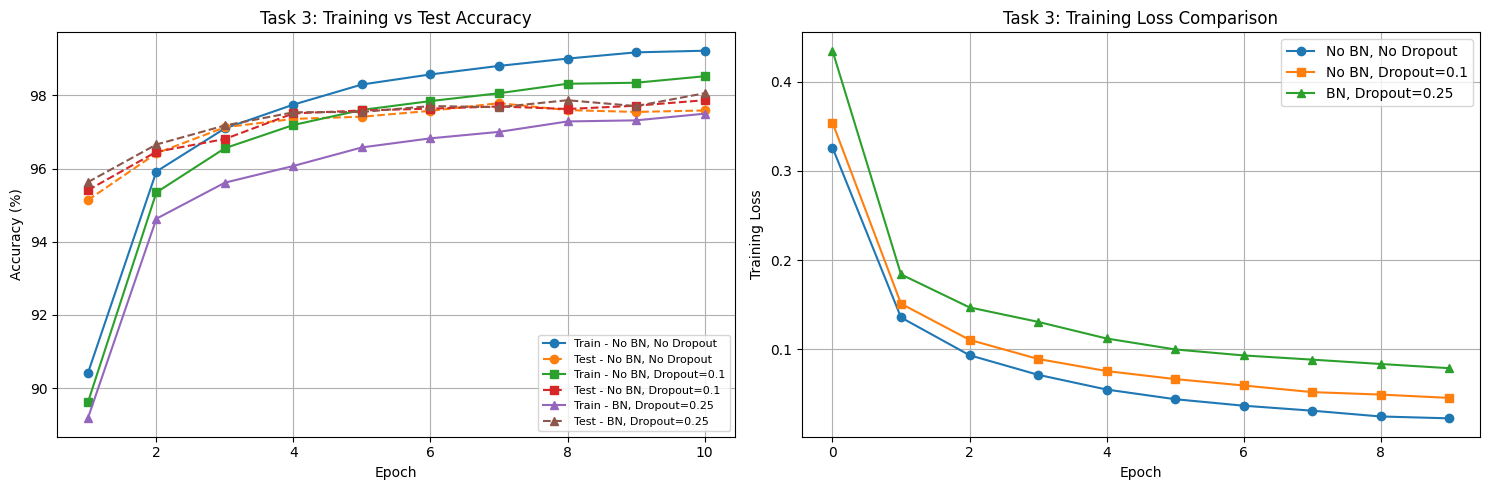


Final Test Accuracies:
No BN, No Dropout: 97.59%
No BN, Dropout=0.1: 97.87%
With BN, Dropout=0.25: 98.06%


In [16]:
# Plot Task 3 Results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training and Test Accuracy Comparison
epochs_range = range(1, 11)

axes[0].plot(epochs_range, results_no_bn_no_drop['train_accs'], label='Train - No BN, No Dropout', linestyle='-', marker='o')
axes[0].plot(epochs_range, results_no_bn_no_drop['test_accs'], label='Test - No BN, No Dropout', linestyle='--', marker='o')
axes[0].plot(epochs_range, results_no_bn_drop01['train_accs'], label='Train - No BN, Dropout=0.1', linestyle='-', marker='s')
axes[0].plot(epochs_range, results_no_bn_drop01['test_accs'], label='Test - No BN, Dropout=0.1', linestyle='--', marker='s')
axes[0].plot(epochs_range, results_bn_drop025['train_accs'], label='Train - BN, Dropout=0.25', linestyle='-', marker='^')
axes[0].plot(epochs_range, results_bn_drop025['test_accs'], label='Test - BN, Dropout=0.25', linestyle='--', marker='^')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Task 3: Training vs Test Accuracy')
axes[0].legend(fontsize=8)
axes[0].grid(True)

# Training Loss Comparison
axes[1].plot(results_no_bn_no_drop['train_losses'], label='No BN, No Dropout', marker='o')
axes[1].plot(results_no_bn_drop01['train_losses'], label='No BN, Dropout=0.1', marker='s')
axes[1].plot(results_bn_drop025['train_losses'], label='BN, Dropout=0.25', marker='^')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Training Loss')
axes[1].set_title('Task 3: Training Loss Comparison')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("\nFinal Test Accuracies:")
print(f"No BN, No Dropout: {results_no_bn_no_drop['final_test_acc']:.2f}%")
print(f"No BN, Dropout=0.1: {results_no_bn_drop01['final_test_acc']:.2f}%")
print(f"With BN, Dropout=0.25: {results_bn_drop025['final_test_acc']:.2f}%")

## Comprehensive Comparison Table

Summary of all experiments conducted in this lab.


In [17]:
# Create comparison table
comparison_data = [
    {
        'Experiment': 1,
        'Activation': 'Sigmoid',
        'Optimizer': 'SGD',
        'BN': 'No',
        'Dropout': 0.0,
        'Epochs': 10,
        'Final Test Accuracy (%)': f"{results_sigmoid['final_test_acc']:.2f}"
    },
    {
        'Experiment': 2,
        'Activation': 'Tanh',
        'Optimizer': 'SGD',
        'BN': 'No',
        'Dropout': 0.0,
        'Epochs': 10,
        'Final Test Accuracy (%)': f"{results_tanh['final_test_acc']:.2f}"
    },
    {
        'Experiment': 3,
        'Activation': 'ReLU',
        'Optimizer': 'SGD',
        'BN': 'No',
        'Dropout': 0.0,
        'Epochs': 10,
        'Final Test Accuracy (%)': f"{results_relu['final_test_acc']:.2f}"
    },
    {
        'Experiment': 4,
        'Activation': 'ReLU',
        'Optimizer': 'SGD + Momentum',
        'BN': 'No',
        'Dropout': 0.0,
        'Epochs': 10,
        'Final Test Accuracy (%)': f"{results_momentum['final_test_acc']:.2f}"
    },
    {
        'Experiment': 5,
        'Activation': 'ReLU',
        'Optimizer': 'Adam',
        'BN': 'No',
        'Dropout': 0.0,
        'Epochs': 10,
        'Final Test Accuracy (%)': f"{results_adam['final_test_acc']:.2f}"
    },
    {
        'Experiment': 6,
        'Activation': 'ReLU',
        'Optimizer': 'Adam',
        'BN': 'No',
        'Dropout': 0.1,
        'Epochs': 10,
        'Final Test Accuracy (%)': f"{results_no_bn_drop01['final_test_acc']:.2f}"
    },
    {
        'Experiment': 7,
        'Activation': 'ReLU',
        'Optimizer': 'Adam',
        'BN': 'Yes',
        'Dropout': 0.25,
        'Epochs': 10,
        'Final Test Accuracy (%)': f"{results_bn_drop025['final_test_acc']:.2f}"
    }
]

df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON TABLE")
print("="*80)
print(df.to_string(index=False))
print("="*80)
print("\nNote: Run all cells above in sequence to generate experiment results.")


COMPREHENSIVE COMPARISON TABLE
 Experiment Activation      Optimizer  BN  Dropout  Epochs Final Test Accuracy (%)
          1    Sigmoid            SGD  No     0.00      10                   75.19
          2       Tanh            SGD  No     0.00      10                   93.87
          3       ReLU            SGD  No     0.00      10                   95.01
          4       ReLU SGD + Momentum  No     0.00      10                   97.78
          5       ReLU           Adam  No     0.00      10                   97.59
          6       ReLU           Adam  No     0.10      10                   97.87
          7       ReLU           Adam Yes     0.25      10                   98.06

Note: Run all cells above in sequence to generate experiment results.


## Final Visualizations

Comprehensive plots showing loss curves and accuracy for different experiments.


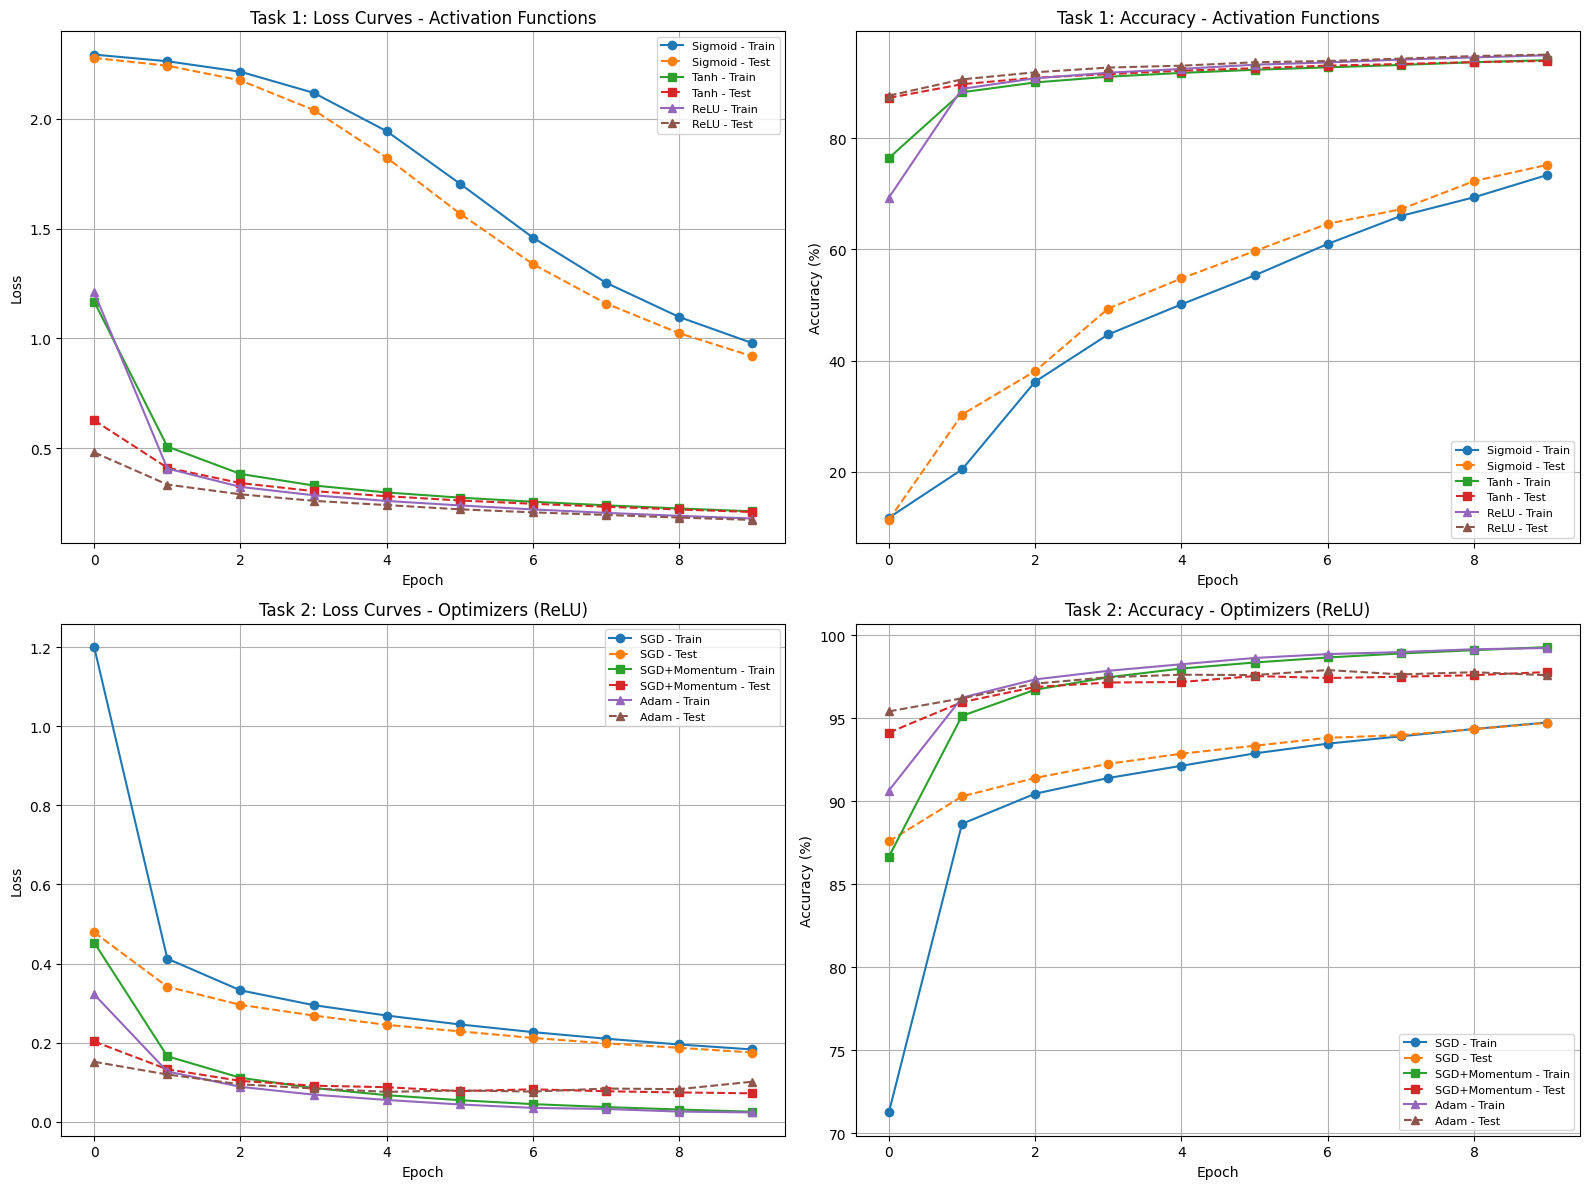

In [20]:
# Comprehensive visualization of all experiments
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Task 1 - Activation Functions (Loss)
axes[0, 0].plot(results_sigmoid['train_losses'], label='Sigmoid - Train', linestyle='-', marker='o')
axes[0, 0].plot(results_sigmoid['test_losses'], label='Sigmoid - Test', linestyle='--', marker='o')
axes[0, 0].plot(results_tanh['train_losses'], label='Tanh - Train', linestyle='-', marker='s')
axes[0, 0].plot(results_tanh['test_losses'], label='Tanh - Test', linestyle='--', marker='s')
axes[0, 0].plot(results_relu['train_losses'], label='ReLU - Train', linestyle='-', marker='^')
axes[0, 0].plot(results_relu['test_losses'], label='ReLU - Test', linestyle='--', marker='^')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Task 1: Loss Curves - Activation Functions')
axes[0, 0].legend(fontsize=8)
axes[0, 0].grid(True)

# Plot 2: Task 1 - Activation Functions (Accuracy)
axes[0, 1].plot(results_sigmoid['train_accs'], label='Sigmoid - Train', linestyle='-', marker='o')
axes[0, 1].plot(results_sigmoid['test_accs'], label='Sigmoid - Test', linestyle='--', marker='o')
axes[0, 1].plot(results_tanh['train_accs'], label='Tanh - Train', linestyle='-', marker='s')
axes[0, 1].plot(results_tanh['test_accs'], label='Tanh - Test', linestyle='--', marker='s')
axes[0, 1].plot(results_relu['train_accs'], label='ReLU - Train', linestyle='-', marker='^')
axes[0, 1].plot(results_relu['test_accs'], label='ReLU - Test', linestyle='--', marker='^')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Task 1: Accuracy - Activation Functions')
axes[0, 1].legend(fontsize=8)
axes[0, 1].grid(True)

# Plot 3: Task 2 - Optimizers (Loss)
axes[1, 0].plot(results_sgd['train_losses'], label='SGD - Train', linestyle='-', marker='o')
axes[1, 0].plot(results_sgd['test_losses'], label='SGD - Test', linestyle='--', marker='o')
axes[1, 0].plot(results_momentum['train_losses'], label='SGD+Momentum - Train', linestyle='-', marker='s')
axes[1, 0].plot(results_momentum['test_losses'], label='SGD+Momentum - Test', linestyle='--', marker='s')
axes[1, 0].plot(results_adam['train_losses'], label='Adam - Train', linestyle='-', marker='^')
axes[1, 0].plot(results_adam['test_losses'], label='Adam - Test', linestyle='--', marker='^')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Task 2: Loss Curves - Optimizers (ReLU)')
axes[1, 0].legend(fontsize=8)
axes[1, 0].grid(True)

# Plot 4: Task 2 - Optimizers (Accuracy)
axes[1, 1].plot(results_sgd['train_accs'], label='SGD - Train', linestyle='-', marker='o')
axes[1, 1].plot(results_sgd['test_accs'], label='SGD - Test', linestyle='--', marker='o')
axes[1, 1].plot(results_momentum['train_accs'], label='SGD+Momentum - Train', linestyle='-', marker='s')
axes[1, 1].plot(results_momentum['test_accs'], label='SGD+Momentum - Test', linestyle='--', marker='s')
axes[1, 1].plot(results_adam['train_accs'], label='Adam - Train', linestyle='-', marker='^')
axes[1, 1].plot(results_adam['test_accs'], label='Adam - Test', linestyle='--', marker='^')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].set_title('Task 2: Accuracy - Optimizers (ReLU)')
axes[1, 1].legend(fontsize=8)
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

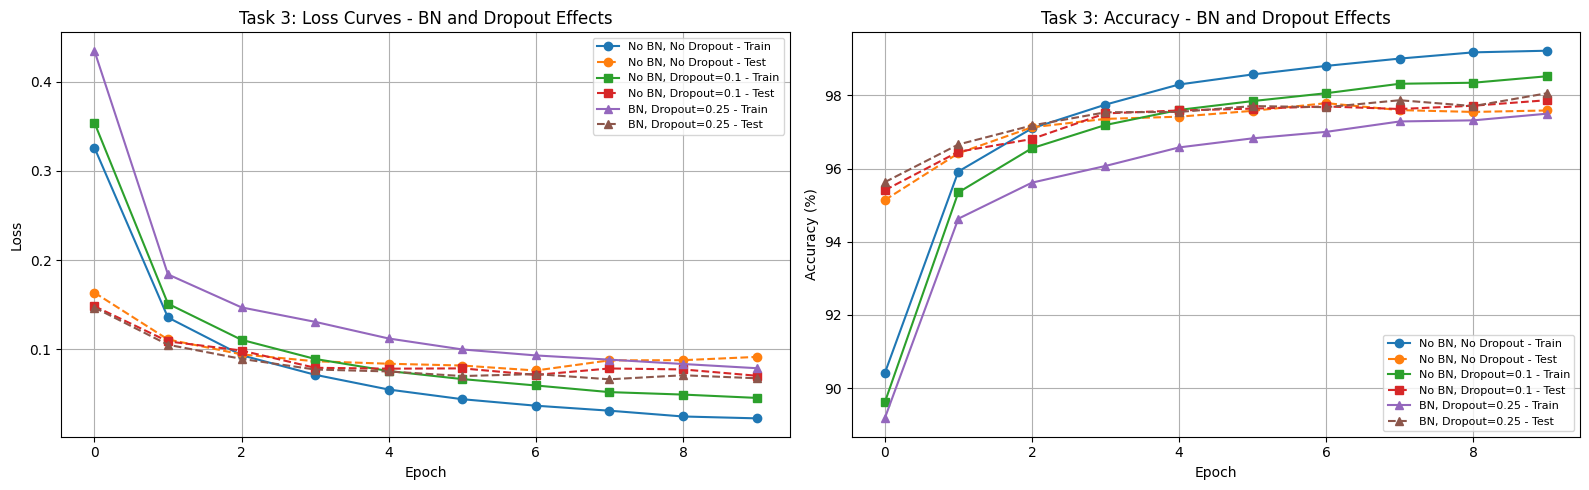

In [19]:
# Task 3 Comprehensive Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Loss curves
axes[0].plot(results_no_bn_no_drop['train_losses'], label='No BN, No Dropout - Train', linestyle='-', marker='o')
axes[0].plot(results_no_bn_no_drop['test_losses'], label='No BN, No Dropout - Test', linestyle='--', marker='o')
axes[0].plot(results_no_bn_drop01['train_losses'], label='No BN, Dropout=0.1 - Train', linestyle='-', marker='s')
axes[0].plot(results_no_bn_drop01['test_losses'], label='No BN, Dropout=0.1 - Test', linestyle='--', marker='s')
axes[0].plot(results_bn_drop025['train_losses'], label='BN, Dropout=0.25 - Train', linestyle='-', marker='^')
axes[0].plot(results_bn_drop025['test_losses'], label='BN, Dropout=0.25 - Test', linestyle='--', marker='^')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Task 3: Loss Curves - BN and Dropout Effects')
axes[0].legend(fontsize=8)
axes[0].grid(True)

# Plot 2: Accuracy curves
axes[1].plot(results_no_bn_no_drop['train_accs'], label='No BN, No Dropout - Train', linestyle='-', marker='o')
axes[1].plot(results_no_bn_no_drop['test_accs'], label='No BN, No Dropout - Test', linestyle='--', marker='o')
axes[1].plot(results_no_bn_drop01['train_accs'], label='No BN, Dropout=0.1 - Train', linestyle='-', marker='s')
axes[1].plot(results_no_bn_drop01['test_accs'], label='No BN, Dropout=0.1 - Test', linestyle='--', marker='s')
axes[1].plot(results_bn_drop025['train_accs'], label='BN, Dropout=0.25 - Train', linestyle='-', marker='^')
axes[1].plot(results_bn_drop025['test_accs'], label='BN, Dropout=0.25 - Test', linestyle='--', marker='^')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Task 3: Accuracy - BN and Dropout Effects')
axes[1].legend(fontsize=8)
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Conclusion

### Summary of Findings:

**Task 1 - Activation Functions:**
- ReLU generally performs best due to avoiding vanishing gradients
- Sigmoid and Tanh can suffer from slower convergence
- ReLU is the most commonly used activation in modern deep learning

**Task 2 - Optimizers:**
- Adam typically converges fastest
- SGD with Momentum provides better stability than basic SGD
- The choice of optimizer significantly impacts training speed

**Task 3 - Regularization:**
- Batch Normalization helps with training stability
- Dropout prevents overfitting
- Combining BN and Dropout usually gives best generalization

**Best Configuration:**
- Activation: ReLU
- Optimizer: Adam
- Regularization: Batch Normalization with moderate Dropout
